In [1]:
import pyarrow.parquet as pq
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import date

In [2]:
t = pq.read_table('fuller_data.parquet')

In [3]:
df = t.to_pandas()
df.drop(['id', 'naid', 'birth date', 'birth_date', 'alias', 'father', 'mother', 'father\'s name', 'mother\'s name', 'sex', ''], axis=1, inplace=True)
df = df[df['naturalization date'] > np.datetime64("1940-01-01")]
df = df[df['naturalization date'] < np.datetime64("1945-12-31")]
df.sort_values(by='anum', inplace=True)
df = df[df.anum<=df.anum.quantile(0.9)]
df = df[df['anum'] > 0]
ndf = df.to_numpy()
df.reset_index(inplace=True)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 388 entries, 0 to 387
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   index                    388 non-null    int64         
 1   country                  388 non-null    object        
 2   port of entry            388 non-null    object        
 3   date of entry            191 non-null    datetime64[ns]
 4   name                     388 non-null    object        
 5   naturalization date      388 non-null    datetime64[ns]
 6   naturalization location  388 non-null    object        
 7   anum                     388 non-null    int64         
dtypes: datetime64[ns](2), int64(2), object(4)
memory usage: 24.4+ KB


In [5]:
anums = df['anum']
x = np.arange(len(anums))
y = anums.to_numpy()

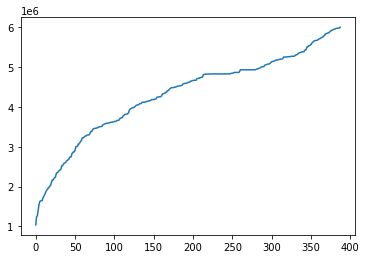

In [6]:
fig, ax = plt.subplots()
ax.plot(x, y)
plt.show()

In [7]:
# Creating Graph
G = nx.Graph()

_last_anum = 0
for index, row in enumerate(ndf):
    nat_loc, anum = row[5], row[6]
    nat_loc = nat_loc.lower().strip().split(',')[0].strip()
    if not isinstance(anum, int) or anum < 0:
        continue
    if np.abs(anum - _last_anum) < 100:
        G.add_edge(_last_anum, anum, weight=1)
    if nat_loc != '':
        G.add_edge(anum, nat_loc, weight=0.1)
    _last_anum = anum
    

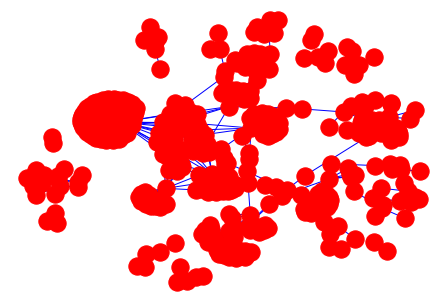

In [8]:
nx.draw(G, node_color='r', edge_color='b')

In [9]:
from networkx.algorithms import community

communities_generator = community.greedy_modularity_communities(G, 'weight')
for c in communities_generator:
    if len(c) < 5: continue
    print(list(sorted(c, key=lambda x: x if isinstance(x, int) else -1)))

['new york', 'st. paul', 1036057, 1621631, 1974590, 2036904, 2236053, 2386002, 2552324, 2685015, 2847330, 3067200, 3154983, 3226837, 3292058, 3381543, 3459245, 3465367, 3490859, 3586602, 3786282, 3815255, 3922384, 3956883, 3970258, 3979881, 3985228, 3989312, 4007813, 4026340, 4083609, 4118164, 4118210, 4122397, 4155916, 4184733, 4186818, 4189244, 4240420, 4258042, 4279252, 4325615, 4331768, 4366130, 4408291, 4418508, 4491241, 4496975, 4501282, 4508755, 4536120, 4594099, 4620668, 4627531, 4717406, 4736993, 4811302, 4816879, 4819951, 4827147, 4827703, 4829604, 4829642, 4829791, 4829860, 4829901, 4829929, 4830500, 4840351, 4845343, 4850842, 4864982, 4866216, 4867371, 4868069, 4881810, 4932889, 4932909, 4932917, 4932928, 4933162, 4943585, 4962693, 4974916, 5007220, 5044527, 5078750, 5134876, 5189212, 5253089, 5264949, 5310595, 5312585, 5329581, 5363791, 5371583, 5427008, 5427504, 5538851, 5538860, 5617984, 5656887, 5678348, 5717424, 5784074, 5788504, 5937322, 5940780, 5984661]
['philadelhi

In [10]:
for i in nx.connected_components(G):
    print(list(sorted(i, key=lambda x: x if isinstance(x, int) else -1)))

['newark', 'philadelhia', 'detroit', 'cleveland', 'tampa', 'boston', 'los angeles', 'san francisco', 'louisville', 'hartford', 'phoenix', 'miami', 'new york', 'st. paul', 'washington', 'chicago', 1036057, 1247938, 1266114, 1405086, 1621631, 1638033, 1645477, 1645490, 1708343, 1747879, 1784735, 1826273, 1915949, 1927827, 1974590, 1980303, 2016380, 2036904, 2164784, 2236053, 2324912, 2349558, 2386002, 2404094, 2418191, 2523227, 2528023, 2552324, 2586229, 2604140, 2641901, 2654944, 2672850, 2685015, 2733797, 2847330, 2872516, 2919740, 3004573, 3005151, 3067200, 3137360, 3154983, 3224156, 3226837, 3257244, 3266472, 3274967, 3292058, 3294623, 3294800, 3300698, 3341973, 3381543, 3449761, 3458037, 3459245, 3465367, 3469603, 3469695, 3490859, 3493428, 3509640, 3509666, 3544637, 3554913, 3565839, 3586602, 3587729, 3590791, 3591196, 3602247, 3609303, 3619160, 3633905, 3634776, 3639268, 3656860, 3659645, 3665236, 3672974, 3716741, 3729639, 3730328, 3786282, 3807003, 3815255, 3821130, 3857095, 392

In [11]:
import pydgraph

schema = """
nat_loc: [uid] @reverse .
people: [uid] @reverse .
name: string @index(exact, term) .
anum: int @index(int) .
nat_date: string @index(exact, term) .

type Person {
    name
    anum
    nat_date
}

type Location {
    name
    people
}

type Root {
    nat_loc
}
"""

In [12]:
stub = pydgraph.DgraphClientStub(f"localhost:{9080}")
dg = pydgraph.DgraphClient(stub)
dg

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 388 entries, 0 to 387
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   index                    388 non-null    int64         
 1   country                  388 non-null    object        
 2   port of entry            388 non-null    object        
 3   date of entry            191 non-null    datetime64[ns]
 4   name                     388 non-null    object        
 5   naturalization date      388 non-null    datetime64[ns]
 6   naturalization location  388 non-null    object        
 7   anum                     388 non-null    int64         
dtypes: datetime64[ns](2), int64(2), object(4)
memory usage: 24.4+ KB


In [14]:
dg.alter(pydgraph.Operation(drop_all=True))
dg.alter(pydgraph.Operation(schema=schema))

In [15]:
txn = dg.txn()

In [16]:
r = txn.mutate(set_obj={
    'uid': '_:root',
    'dgraph.type': 'Root',
})
root_uid = r.uids['root']

In [17]:
locs = dict()
people = dict()

_last_anum = 0
for index, row in enumerate(ndf):
    name, nat_loc, nat_date, anum = row[3], row[5], row[4], row[6]
    nat_loc = nat_loc.lower().strip().split(',')[0].strip()
    if not isinstance(anum, int) or anum <= 0:
        continue
    if nat_loc not in locs:
        r = txn.mutate(set_obj={
            'uid': '_:' + str(hash(nat_loc)),
            'dgraph.type': 'Location',
            'name': nat_loc,
        })
        uid = r.uids[str(hash(nat_loc))]
        locs[nat_loc] = uid
        
    r = txn.mutate(set_obj={
        'uid': '_:' + str(anum),
        'dgraph.type': 'Person',
        'name': name,
        'anum': anum,
        'nat_date': str(nat_date),
    })
    p_uid = r.uids[str(anum)]
    
    txn.mutate(set_obj={
        'uid': locs[nat_loc],
        'people': [{'uid': p_uid}]
    })

In [18]:
txn.mutate(set_obj={
    'uid': root_uid,
    'nat_loc': [
        {'uid': uid}
        for uid in locs.values()
    ]
})
None

In [19]:
txn.commit()
print('http://localhost:8000')

http://localhost:8000
